# KSA: Polar Observations and Modelling

## Week X, Class 2 - Hydrographic sections

To monitor the evolution of the climate system, it is important to sustain a network of long-term observations. Part of this network in the ocean is the repetition of hydrographic transects (or cross sections) at key locations within the [GO-SHIP](https://www.go-ship.org/index.html) program. 

These surveys are typically carried out once a decade (at least) since the 1970s, in every ocean basin. You can see a map of the hydrographic lines [here](https://www.go-ship.org/RefSecs/goship_ref_secs.html), as well as the countries involved. 

This class we are going to work with the I09S cross section that runs from the Antarctic continent to Fremantle at around 120E. We will start by taking a look at the historic occupations, and then compare to the most recent survey part of the [(MISO)](https://aappartnership.org.au/miso/) voyage. 

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cft
import cmocean as cm
import glob
import gsw
import matplotlib.pyplot as plt
import metpy
import numpy as np
import xarray as xr

## Historic I09S occupations

We can download past I09S occupations from [here](https://cchdo.ucsd.edu/products/goship-easyocean). Easy ocean provides a gridded product, where every cast was interpolated to the same latitude, longitude point and the same depth levels. This makes it really easy to compare between occupations!

In [2]:
I09S = xr.open_dataset('data/i09s.nc')

In [3]:
I09S

<xarray.Dataset>
Dimensions:                   (gridded_section: 3, longitude: 1, latitude: 311,
                               pressure: 651)
Coordinates:
  * gridded_section           (gridded_section) float64 1.0 2.0 3.0
  * longitude                 (longitude) float64 114.7
  * latitude                  (latitude) float64 -65.4 -65.3 ... -34.5 -34.4
  * pressure                  (pressure) float64 0.0 10.0 ... 6.49e+03 6.5e+03
Data variables:
    time                      (latitude, gridded_section) datetime64[ns] ...
    temperature               (pressure, latitude, longitude, gridded_section) float64 ...
    practical_salinity        (pressure, latitude, longitude, gridded_section) float64 ...
    oxygen                    (pressure, latitude, longitude, gridded_section) float64 ...
    conservative_temperature  (pressure, latitude, longitude, gridded_section) float64 ...
    absolute_salinity         (pressure, latitude, longitude, gridded_section) float64 ...
Attributes: (12/36)
    program:                       GO-Ship Easy Ocean. WOCE and GO-Ship gridd...
    Conventions:                   CF-1.7 ACDD-1.3
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         Gridded CTD product from WOCE and GO-Ship ...
    date_issued:                   20230927
    abstract:                      Ship-based hydrographic data are essential...
    ...                            ...
    creator_email:                 k.katsumata@jamstec.go.jp
    lineage:                       Data were created as described at: https:/...
    citation:                      The citation in a list of references is: "...
    acknowledgement:               Data were collected and made publicly avai...
    disclaimer:                    Data, products and services from CCHDO are...
    license:                       http://creativecommons.org/licenses/by/4.0/

Let's plot temperature for the first occupation:

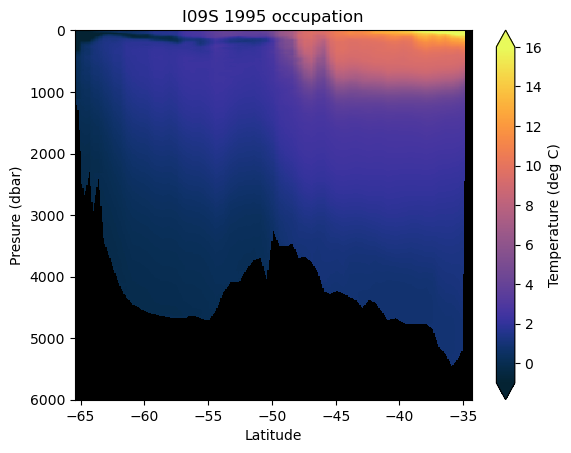

In [4]:
I09S['temperature'].isel(gridded_section = 0).squeeze().plot(vmin = -1, vmax = 16, cmap = cm.cm.thermal,
                                                             cbar_kwargs = {'label':'Temperature (deg C)'})
plt.gca().invert_yaxis()
plt.title('I09S 1995 occupation')
plt.xlabel('Latitude')
plt.ylabel('Presure (dbar)');
plt.ylim(6000, None);
plt.gca().set_facecolor('k');


Now we know the code works, we can extend it to plot all the occupations, side by side:

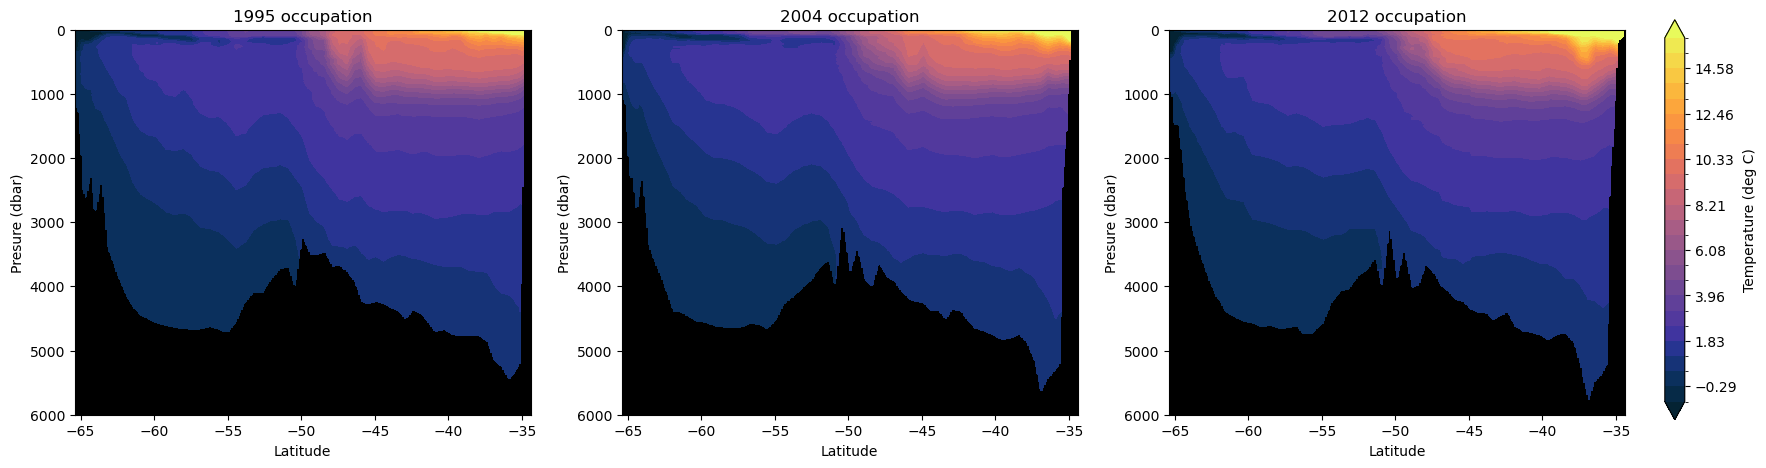

In [5]:
fig = plt.figure(figsize = (20,5))
axs = [fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)]

I09S['temperature'].isel(gridded_section = 0).squeeze().plot.contourf(ax = axs[0], vmin = -1, vmax = 16, 
                                                                      cmap = cm.cm.thermal, levels = 25,
                                                                      add_colorbar = False)
I09S['temperature'].isel(gridded_section = 1).squeeze().plot.contourf(ax = axs[1], vmin = -1, vmax = 16, 
                                                                      cmap = cm.cm.thermal, levels = 25,
                                                                      add_colorbar = False)
cp = I09S['temperature'].isel(gridded_section = 2).squeeze().plot.contourf(ax = axs[2], vmin = -1, vmax = 16, 
                                                                           cmap = cm.cm.thermal, levels = 25,
                                                                           add_colorbar = False)

cbax = plt.axes([0.92, 0.1, 0.01, 0.8])
cbar = plt.colorbar(cp, cax = cbax, orientation = 'vertical')
cbar.ax.set_ylabel('Temperature (deg C)')

for ax in axs:
    ax.invert_yaxis()
    ax.set_ylim(6000, None)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Presure (dbar)');   
    ax.set_facecolor('k');
axs[0].set_title('1995 occupation')
axs[1].set_title('2004 occupation')
axs[2].set_title('2012 occupation');

#### Question 1

**a.** Plot salinity and oxygen. Describe the features you see in these cross sections. 

**b.** Can you identify any changes between occupations?

**Suggestion: try plotting the difference between 2012 and 2004, or 2004 and 1995. Is this of any help?**

*Spoiler: the plot above is not easy to understand! There will be a number of small scale features, specially at the surface and some "stripey" patterns throughout the water column. Remember that these hydrographic surveys represent a snapshot in time. These snapshots include eddies, meanders and other types of high frequency variability in the ocean that would average out if we were taking a long enough period.*

*Answer here*

## Latest occupation

The latest occupation during February 2024 has not yet made its way to the EasyOcean GO-SHIP product yet. But we can use the individual CTD profiles to interpolate to the same points as the historical occupations and look at the most recent changes.
 
First, open the CTD files like we did last class:

In [6]:
path_to_files = glob.glob('data/*Ctd*') 
path_to_files = np.sort(path_to_files)

CTDs = {}; lat = []; lon = []
for i in range(0, len(path_to_files)):
    CTDs[i] = xr.open_dataset(path_to_files[i])
    lat.append(CTDs[i]['latitude'].item())
    lon.append(CTDs[i]['longitude'].item())

Let's remind ourselves of the locations of these casts:

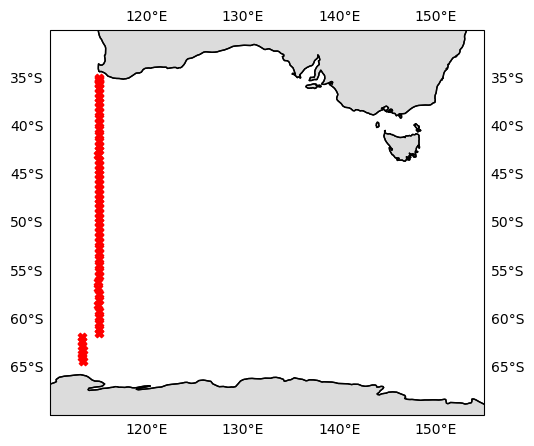

In [7]:
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(projection = ccrs.PlateCarree(central_longitude = 130))
ax.set_extent([110, 155, -70, -30], crs = ccrs.PlateCarree())
ax.add_feature(cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gainsboro'))
ax.coastlines(resolution = "50m")
gl = ax.gridlines(draw_labels = True, linewidth = 0)
gl.xformatter = ccrs.cartopy.mpl.ticker.LongitudeFormatter()
gl.yformatter = ccrs.cartopy.mpl.ticker.LatitudeFormatter()
ax.scatter(lon, lat, marker = 'X', color = 'red', transform = ccrs.PlateCarree());

In order to make an I09S section like the EasyOcean one, we need to interpolate twice:

1. First we need to interpolate our pressure levels to those in the EasyOcean grid.
2. Second, we need to interpolate our (lat, lon) points to those in the EasyOcean grid.

Lets start with the interpolation of the pressure level. We will create empty `xr.DataArray`s for each variable and fill them with the profiles interpolated to the EasyOcean pressure levels.

In [9]:
temp_interp = xr.DataArray(np.empty([len(I09S['pressure']), len(CTDs)]),
                           coords = {'pressure': I09S['pressure'].values,
                                     'CTD_number': np.arange(0, len(CTDs), 1)})
for i in range(0, len(CTDs)):
    CTD_interp = CTDs[i].interp(pressure = I09S['pressure'].values, method = 'linear').squeeze()
    temp_interp.loc[{'CTD_number':i}] = CTD_interp['temperature'].values

Add to these `DataArrays` the latitude, longitude information:

In [10]:
temp_interp = temp_interp.assign_coords(longitude = ('CTD_number', lon), latitude = ('CTD_number', lat))

Use `metpy` to interpolate these to the I09S points:

In [11]:
help(metpy.interpolate.interpolate_to_points)

Help on function interpolate_to_points in module metpy.interpolate:

interpolate_to_points(points, values, xi, interp_type='linear', minimum_neighbors=3, gamma=0.25, kappa_star=5.052, search_radius=None, rbf_func='linear', rbf_smooth=0)
    Interpolate unstructured point data to the given points.
    
    This function interpolates the given `values` valid at ``points`` to the points `xi`.
    This is modeled after `scipy.interpolate.griddata`, but acts as a generalization of it by
    including the following types of interpolation:
    
    - Linear
    - Nearest Neighbor
    - Cubic
    - Radial Basis Function
    - Natural Neighbor (2D Only)
    - Barnes (2D Only)
    - Cressman (2D Only)
    
    Parameters
    ----------
    points: array-like, (N, P)
        Coordinates of the data points.
    values: array-like, (N,)
        Values of the data points.
    xi: array-like, (M, P)
        Points to interpolate the data onto.
    interp_type: str
        What type of interpolation t

In [12]:
points = np.stack([lon, lat], axis = 1)
values = temp_interp.transpose().values
xi = np.stack([np.ones(len(I09S['latitude']))*I09S['longitude'].values, I09S['latitude'].values], axis = 1)

In [58]:
I09S_new_temperature = metpy.interpolate.interpolate_to_points(points, values, xi, interp_type = 'nearest')
# Create a dataarray
I09S_new_temperature = xr.DataArray(np.transpose(I09S_new_temperature), 
                                    coords = I09S['temperature'].isel(gridded_section = 0).squeeze().coords,
                                    name = 'temperature')

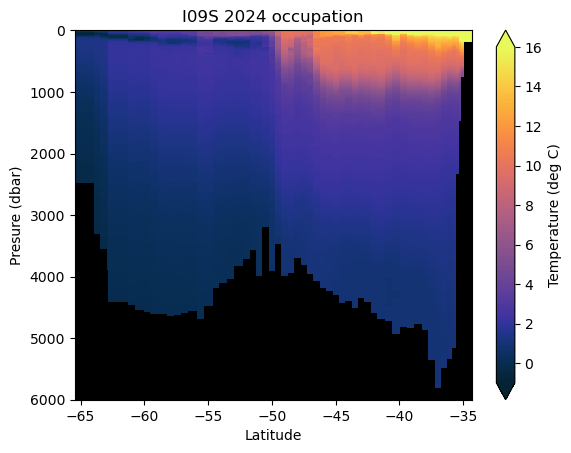

In [14]:
I09S_new_temperature.plot(vmin = -1, vmax = 16, cmap = cm.cm.thermal,
                          cbar_kwargs = {'label':'Temperature (deg C)'})
plt.gca().invert_yaxis()
plt.title('I09S 2024 occupation')
plt.xlabel('Latitude')
plt.ylabel('Presure (dbar)');
plt.ylim(6000, None);
plt.gca().set_facecolor('k');

What we have done is a very crude interpolation. We can see that the section does not look as smooth as the historic observations from the EasyOcean dataset. This is because, as you can read in the [GO-SHIP paper](https://www.nature.com/articles/s41597-022-01212-w), there are several filters applied to the interpolation to smooth out features that are beyond of the scope of what we are trying to do here. For our purposes this interpolation is fine!

#### Question 2

Repeat the interpolation for practical salinity and oxygen, and make a figure with three panels (one for temperature, one for salinity and one for oxygen). 

*Answer here*

#### Question 3

**a.** Using `gsw` calculate conservative temperature and absolute salinity for I09S. You can look at the `2_Multiple_CTDs.ipynb` for guidance. Plot them in a figure with two panels.

**b.** Merge the temperature, practical salinity, conservative temperature, absolute salinity and oxygen dataarrays into one dataset, and save using the `.to_netcdf(path_to_save/name.nc)` function. You can compare your saved file to `data/I09S_2024.nc` to verify it was done correctly.

*Answer here*